### Vector Database

Necessari per archiviare ed interrogare dati non strutturati (cioè dati che non corrispondono a schemi prefissati come immagini, testo, audio ecc).

Per le ricerche utilizzano "similarity metric"

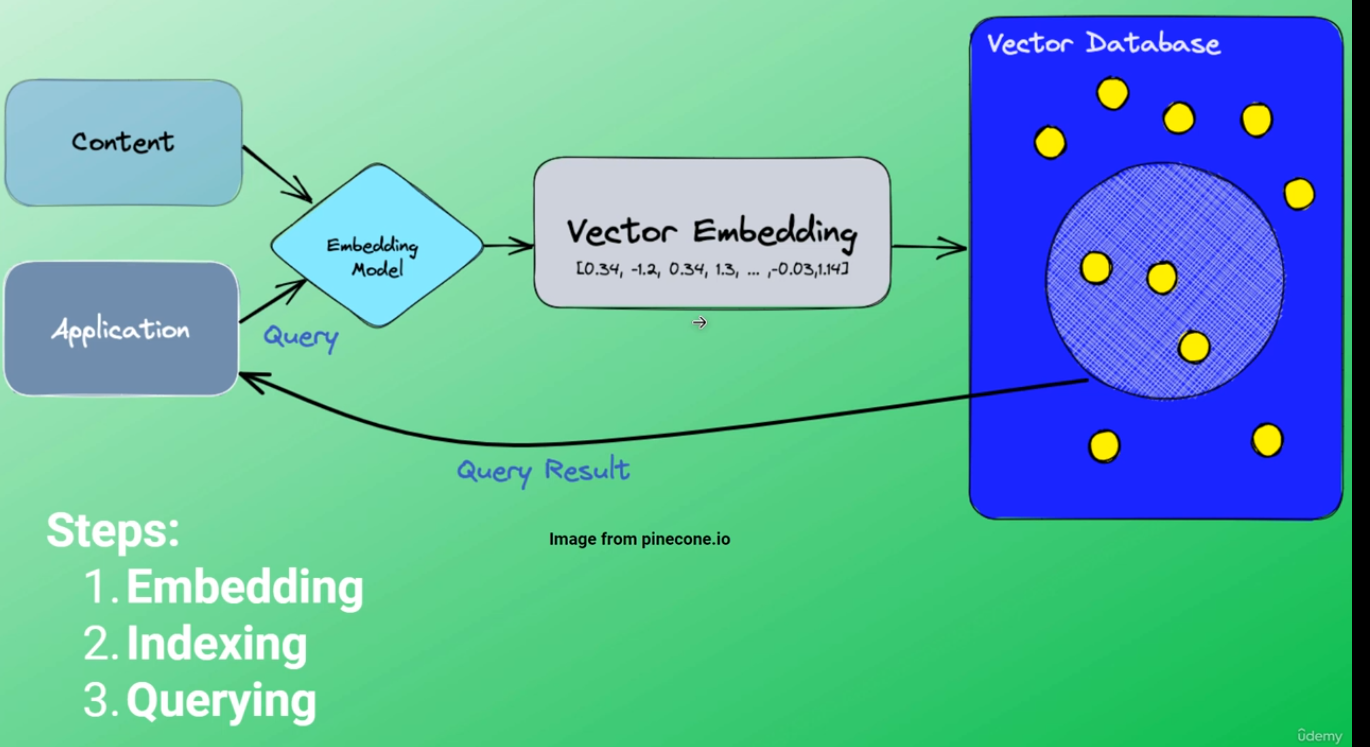

La libreria per interagire con Pinecone dovrebbe essere stata installata dai requirements.txt

In [5]:
!pip install --upgrade -q pinecone-client

Dopo aver creato un account su pinecone.io, aver generato una API KEY e aver inserito la KEY nel .env file, carico la chiave nella variabile di ambiente

In [2]:
!pip show pinecone-client

Name: pinecone-client
Version: 5.0.1
Summary: Pinecone client and SDK
Home-page: https://www.pinecone.io
Author: Pinecone Systems, Inc.
Author-email: support@pinecone.io
License: Apache-2.0
Location: /home/michele/anaconda3/envs/langchain_env/lib/python3.12/site-packages
Requires: certifi, pinecone-plugin-inference, pinecone-plugin-interface, tqdm, typing-extensions, urllib3
Required-by: 


In [3]:
import os
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv(), override=True)

os.environ.get('PINECONE_API_KEY')

'56728b65-ffa0-4549-b222-f895dca89d26'

In [8]:
from pinecone import Pinecone

pc = Pinecone()

pc.list_indexes()
pc.config

Config(api_key='56728b65-ffa0-4549-b222-f895dca89d26', host='https://api.pinecone.io', proxy_url=None, proxy_headers=None, ssl_ca_certs=None, ssl_verify=None, additional_headers={}, source_tag=None)

Un index è il più alto livello di organizzazione di una unità di vector data 

In [9]:
pc.list_indexes().names()

['langchain']

CReo un index

In [10]:
# Importo la configurazione per creare un pod based index (il piano gratuito consente un solo index)

from pinecone import PodSpec

index_name = "langchain"

if index_name not in pc.list_indexes().names():
    print(f"Creo indice {index_name}")
    pc.create_index(
        name=index_name,
        dimension=1536, #default
        metric="cosine",
        spec=PodSpec(
            environment="gcp-starter"
        )
    )
    print("Index created")
else:
    print(f"Index {index_name} esiste già")

Index langchain esiste già


Posso visualizzare l'index creato dalla console di Pinecone all'url https://app.pinecone.io/

Per fare qualsiasi operazione su un index devo prima selezionarlo

In [11]:
index = pc.Index(index_name)
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

### Vectors

Dopo aver generato l'index, genero alcuni vettori da utilizzare con l'index

In [12]:
import random

# Genero 5 vettori di dimensione 1536

vectors = [[random.random() for _ in range(1536)] for v in range(5)]
print(vectors[0][0])

0.8073048227242704


Per inserire un vettore è necessario l'ID di ciascun vettore che si vuole inserire.<br>
Nel caso di 5 vettori sono necessari 5 id

In [13]:
ids = list('abcde')

# seleziono l'index
index = pc.Index(index_name)

# Inserisce un nuovo vettore o lo aggiorna se esiste già
index.upsert(vectors=zip(ids, vectors))

{'upserted_count': 5}

In [25]:
# Per aggiornare un vectore
index.upsert(vectors=[('c', [0.5] * 1536)])

{'upserted_count': 1}

In [26]:
# Fetching Vectors

# seleziono l'index
index = pc.Index(index_name)

index.fetch(ids=['c', 'd'])

{'namespace': '',
 'usage': {'read_units': 1},
 'vectors': {'c': {'id': 'c',
                   'values': [0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
                              0.5,
             

In [29]:
# DElete Vectors

index.delete(ids=['b', 'c'])

{}

In [15]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 5e-05,
 'namespaces': {'': {'vector_count': 5}},
 'total_vector_count': 5}

In [16]:
# Creo Query Vector

query_vector = [random.random() for _ in range(1536)]

# che utilizzo per fare una query ed estrarre l'ID del vettore più simile al query vector

index.query(
    vector=query_vector,
    top_k=3,
    include_values=False
)

{'matches': [{'id': 'c', 'score': 0.757879615, 'values': []},
             {'id': 'e', 'score': 0.755964398, 'values': []},
             {'id': 'a', 'score': 0.752848506, 'values': []}],
 'namespace': '',
 'usage': {'read_units': 5}}

### Namespaces

I vectors all'interno di un index possono essere partizionati in namespaces e le query ed altre operazioni devono considerare questi namespaces.
- Un indice contiene più namespaces
- Un vector può esistere in un solo namespace
- Ogni namespace è identificato da un nome univoco (default "empty string")

Per inserire un vector in uno specifico namespace è sufficiente passare come parametro il nome del namespace nel metodo upsert(). Se non si passa nulla i vectors sono inseriti nel defaul namespace

In [17]:
# Genero 3 vettori di dimensione 1536

vectors = [[random.random() for _ in range(1536)] for v in range(3)]

ids = list('xyz')

# seleziono l'index
index = pc.Index(index_name)

# Inserisce un nuovo vettore o lo aggiorna se esiste già
index.upsert(vectors=zip(ids, vectors), namespace="first-namespace")

{'upserted_count': 3}

In [18]:
# Genero 3 vettori di dimensione 1536

vectors = [[random.random() for _ in range(1536)] for v in range(2)]

ids = list('qp')

# seleziono l'index
index = pc.Index(index_name)

# Inserisce un nuovo vettore o lo aggiorna se esiste già
index.upsert(vectors=zip(ids, vectors), namespace="second-namespace")

{'upserted_count': 2}

In [19]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0001,
 'namespaces': {'': {'vector_count': 5},
                'first-namespace': {'vector_count': 3},
                'second-namespace': {'vector_count': 2}},
 'total_vector_count': 10}

In [21]:
# Cerca nel default namespace (e non trova il vector) 

index.fetch(ids=['x'])

{'namespace': '', 'usage': {'read_units': 1}, 'vectors': {}}

In [22]:
# Cerca nel namespace corretto (e trova il vector) 

index.fetch(ids=['x'], namespace="first-namespace")

{'namespace': 'first-namespace',
 'usage': {'read_units': 1},
 'vectors': {'x': {'id': 'x',
                   'values': [0.194375351,
                              0.180038214,
                              0.757931352,
                              0.185341418,
                              0.183261424,
                              0.512156546,
                              0.506899059,
                              0.27041617,
                              0.951908767,
                              0.518364489,
                              0.375640273,
                              0.182112619,
                              0.0927516893,
                              0.671303928,
                              0.594047546,
                              0.822511077,
                              0.832600117,
                              0.621734202,
                              0.881047606,
                              0.433970898,
                              0.278065056,
     

Per cancellare tutti i vectors di un namespace

In [23]:
index.delete(delete_all=True, namespace="second-namespace")

{}

In [24]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 8e-05,
 'namespaces': {'': {'vector_count': 5},
                'first-namespace': {'vector_count': 3}},
 'total_vector_count': 8}